In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer

from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

from sklearn.neighbors import BallTree
from shapely.geometry import Point

import geopandas as gpd
import xarray as xr
import rioxarray  # For handling raster data with xarray
from shapely.geometry import Point, mapping
import numpy as np
import pandas as pd
import math


# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load


In [2]:
def get_gdf(path="Training_data_uhi_index_2025-02-18.csv", crs="EPSG:4326"):
    df = pd.read_csv(path)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=[Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])],
        crs="EPSG:4326"
    ).to_crs(crs)
    return gdf
train_gdf = get_gdf()
train_gdf

,Longitude,Latitude,datetime,UHI Index,geometry
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (-73.90917 40.81311)
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (-73.90919 40.81305)
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (-73.90922 40.81298)
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (-73.90924 40.81291)
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (-73.90926 40.81285)
...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,POINT (-73.95705 40.79033)
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,POINT (-73.95706 40.79031)
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,POINT (-73.95709 40.79027)
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,POINT (-73.95711 40.79025)


# DATA Acquisition / Feature Engineering

The Data used is mainly:
- Satellite Data : Accessible via planetary computer
- LandCover segmentation : Open dataset accesible via https://zenodo.org/records/14053441
- Building Footprints : Provided by the organizing team


## Satellite Data

This first piece of code retrieves satellite imagery from two different sensors—Sentinel-2 and Landsat—and computes a range of spectral indices that are useful for analyzing urban heat island (UHI) phenomena. 
Computed Indices and Their Role in UHI Estimation

The code computes several indices from the spectral bands, each of which highlights different land surface properties relevant to UHI studies:

 - Vegetation and Water Indices (NDVI, NDWI, EVI, EVI2, SAVI, EVMI):
These indices quantify vegetation health and water content. 

- Urban and Impervious Surface Indices (NDBI, UI, NDISI, BUI, EBBI, ABI):
Urban areas with high impervious surface cover (roads, buildings) tend to absorb and re-emit more heat. These indices help distinguish built-up areas from vegetated or water bodies, thereby identifying zones that are more prone to heating.

- Thermal and Temperature Indices (LST_Proxy, LST, BT, UTFVI, TEI, THI):
Land Surface Temperature (LST) proxies and thermal indices are critical for UHI studies because they directly estimate surface temperature differences.

- Reflectance and Albedo (Albedo, MNDWI, BSI):
Surface albedo, or the reflectance of the ground, influences how much solar radiation is absorbed or reflected. Lower albedo in urban settings typically leads to higher heat absorption.

- Additional Specialized Indices (UTI, NDCI, SI, REIP, EVMI, VGI, VSTR, EUHI):
More complex indices combine thermal and spectral information (e.g., UTI, EVMI, VGI) to provide insights into the urban thermal environment, including aspects like building materials, surface moisture, and the impact of shadowing. These can reveal the heterogeneity of urban surfaces and the varying contributions to UHI.

By combining these diverse indices, we can feed the model with as many inputs that:

- Characterize Urban Surfaces: Identify and differentiate between urban built-up areas, vegetated zones, and water bodies.
- Assess Thermal Patterns: Directly map surface temperatures and thermal gradients, which are crucial for pinpointing urban heat islands.

In [ ]:
def getDatafromS2():
    # Define the time window
    time_window = "2021-07-01/2021-08-05"
    # bounding Box
    lower_left = (40.70, -74.05)
    upper_right = (40.90, -73.80)

    # Calculate the bounds for doing an archive data search
    # bounds = (min_lon, min_lat, max_lon, max_lat)
    bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    search = stac.search(
        bbox=bounds, 
        datetime=time_window,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 30}},
    )
    items = list(search.get_items())
    print('Number of Sentinel2 scenes that touch our region:',len(items))

    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 

    data = stac_load(
        items,
        bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A","B09", "B11", "B12", "AOT", "WVP", "SCL"],
        crs="EPSG:4326", # Latitude-Longitude
        resolution=scale, # Degrees
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=planetary_computer.sign,
        bbox=bounds
    )

    data['NDVI'] = (data['B08'] - data['B04']) / (data['B08'] + data['B04'] + 1e-6)
    data['NDBI'] = (data['B11'] - data['B08']) / (data['B11'] + data['B08'] + 1e-6)

    data['NDWI'] = (data['B03'] - data['B08']) / (data['B03'] + data['B08'])

    data['EVI'] = 2.5 * ( (data['B08'] - data['B04']) / (data['B08'] + 6 * data['B04'] - 7.5 * data['B03'] + 1) )

    data['BSI'] = ((data['B11'] + data['B04']) - (data['B08'] + data['B02'])) / ((data['B11'] + data['B04']) + (data['B08'] + data['B02']))

            # Land Surface Temperature (LST) Proxy
    data['LST_Proxy'] = data['B11'] - data['B12']
            # Albedo (average reflectance of visible bands)
    data['Albedo'] = (data['B02'] + data['B03'] + data['B04']) / 3
            # Modified Normalized Difference Water Index (MNDWI)
    data['MNDWI'] = (data['B03'] - data['B11']) / (data['B03'] + data['B11'])
            # Urban Index (UI)
    data['UI'] = (data['B11'] - data['B04']) / (data['B11'] + data['B04'])
            # Enhanced Built-Up and Bareness Index (EBBI)
    data['EBBI'] = (data['B11'] - data['B08']) / (data['B11'] + data['B08'])


    # 1. Urban Thermal Index (UTI)
    data['UTI'] = (data['B11'] + data['B12']) / (data['B08'] + 1e-6)

    # 2. Normalized Difference Concrete Index (NDCI)
    data['NDCI'] = (data['B11'] - data['B04']) / (data['B11'] + data['B04'] + 1e-6)

    # 3. Enhanced Vegetation Moisture Index (EVMI)
    data['EVMI'] = (data['B8A'] - data['B11']) / (data['B8A'] + data['B11'] + 1e-6)

    # 4. Shadow Index (SI)
    data['SI'] = (data['B02'] - data['B03'] - data['B04']) / (data['B02'] + data['B03'] + data['B04'] + 1e-6)

    # 5. Red Edge Inflection Point (REIP) - Vegetation stress
    data['REIP'] = 700 + 40 * ((data['B05'] + data['B07']) / 2 - data['B04']) / (data['B06'] - data['B04'] + 1e-6)

    # 6. Advanced Built-Up Index (ABI)
    data['ABI'] = (data['B11'] * data['B12']) / (data['B03'] + data['B04'] + 1e-6)

    # 7. Thermal Exposure Index (TEI)
    data['TEI'] = data['LST_Proxy'] * data['NDBI']

    # 8. Surface Moisture Index (SMI)
    data['SMI'] = (data['B8A'] - data['B12']) / (data['B8A'] + data['B12'] + 1e-6)

    # 9. Composite Urban Index (CUI)
    data['CUI'] = (data['NDBI'] + data['UI'] + data['EBBI']) / 3

    # 10. Anthropogenic Heat Index (AHI)
    data['AHI'] = (data['B12'] - data['B8A']) / (data['B12'] + data['B8A'] + 1e-6) * data['NDBI']

    # 11. Vertical Gradient Index (VGI) - Building height proxy
    data['VGI'] = (data['B8A'] - data['B04']) / (data['B8A'] + data['B04'] + 1e-6) * data['NDBI']

    data = data.drop_vars(["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A","B09", "B11", "B12", "AOT", "WVP", "SCL"])
    # data = data.persist()
    # data.to_netcdf('Satellite_Data/S2_data_Indices.nc')
    return data


def getDatafromLandSat():

    
    # Define the time window
    time_window = "2021-06-01/2021-09-01"
    # bounding Box

    lower_left = (40.70, -74.05)
    upper_right = (40.90, -73.80)

    # Calculate the bounds for doing an archive data search
    # bounds = (min_lon, min_lat, max_lon, max_lat)
    bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    search = stac.search(
        bbox=bounds, 
        datetime=time_window,
        collections=["landsat-c2-l2"],
        query={
                "eo:cloud_cover": {"lt": 30},
               "platform": {"in": ["landsat-8", "landsat-9"]}},
    )
    items = list(search.get_items())
    print('Number of Landsat scenes that touch our region:',len(items))
    # signed_items = [planetary_computer.sign(item).to_dict() for item in items]

    resolution = 10  # meters per pixel 
    # scale = resolution / 111320.0 # degrees per pixel for crs=4326 
    scale = resolution / (111320 * math.cos(math.radians(40.7)))

    data = stac_load(
        items,
        # bands=['red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal'],
        bands=["red", "green", "blue", "nir08", "swir16", "lwir11"],
        crs="EPSG:4326", # Latitude-Longitude
        resolution=scale, # Degrees
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=planetary_computer.sign,
        bbox=bounds
    )
    def safe_divide(a, b):
        return xr.where(b != 0, a / b, 0)


    K1, K2, lambda_w, c2, emissivity= 774.89, 1321.08, 10.895, 14380, 0.95

    scale1, offset1 = 0.0000275, -0.2 
    
    scaled_bands = data[["red", "green", "blue", "nir08"]].apply(
                                        lambda x: x.astype(float) * scale1 + offset1
                                            )
    data[["red", "green", "blue", "nir08"]] = scaled_bands
    
    scale2, offset2, kelvin_celsius = 0.00341802, 149.0, 273.15 # convert from Kelvin to Celsius
    data["lwir11"] = data["lwir11"].astype(float) * scale2 + offset2 - kelvin_celsius


    """Normalized Difference Vegetation Index (NDVI)"""
    data['NDVI_Landsat'] = safe_divide((data["nir08"] - data["red"]) , (data["nir08"] + data["red"]))
    """Green Normalized Difference Vegetation Index (GNDVI)"""
    data['GNDVI_Landsat'] = safe_divide((data["nir08"] - data["green"]), (data["nir08"] + data["green"]))

    data['EVI_Landsat'] =  safe_divide(2.5 * (data["nir08"] - data["red"]) , (data["nir08"] + 6 * data["red"] - 7.5 * data["blue"] + 1))
    data['NDWI_Landsat'] = safe_divide((data["green"] - data["nir08"]), (data["green"] + data["nir08"]))

    data['MNDWI_Landsat'] = safe_divide((data["green"] - data["lwir11"]), (data["green"] + data["lwir11"]))
    data['NDBI_Landsat'] = safe_divide((data["lwir11"] - data["nir08"]), (data["lwir11"] + data["nir08"]))

    data['BUI_Landsat'] =  data['NDBI_Landsat'] - data['NDVI_Landsat']

    data['NDBSI_Landsat'] = safe_divide((data["lwir11"] - data["green"]), (data["lwir11"] + data["green"]))
    data['BI_Landsat'] = safe_divide((data["red"] * data["green"]), data["nir08"])

    data["BT_Landsat"] = K2 / np.log((K1 / data["lwir11"]) + 1)
    data['LST_Landsat'] = safe_divide(data["BT_Landsat"], (1 + (data["lwir11"] * data["BT_Landsat"] / c2) * np.log(emissivity)))

    # --- Compute the Urban Thermal Field Variance Index (UTFVI) ---
    # Compute per time slice: Normalize LST for each time independently
    lst_min = data['LST_Landsat'].min(dim=['latitude', 'longitude'])
    lst_max = data['LST_Landsat'].max(dim=['latitude', 'longitude'])
    data['UTFVI_Landsat'] = safe_divide((data['LST_Landsat'] - lst_min), (lst_max - lst_min))

    # 1. Enhanced Vegetation Index (EVI2) - Less atmosphere sensitive than EVI
    data['EVI2_Landsat'] = 2.5 * safe_divide((data["nir08"] - data["red"]), (data["nir08"] + 2.4 * data["red"] + 1))
    
    # 2. Soil Adjusted Vegetation Index (SAVI) - Accounts for bare soil
    L = 0.5  # Soil adjustment factor
    data['SAVI_Landsat'] = (1 + L) * safe_divide((data["nir08"] - data["red"]), (data["nir08"] + data["red"] + L))
    
    # 3. Normalized Difference Impervious Index (NDISI) - Impervious surfaces
    data['NDISI_Landsat'] = safe_divide((data["lwir11"] - (data["green"] + data["nir08"])/2),
                           (data["lwir11"] + (data["green"] + data["nir08"])/2))
    
    # 4. Urban Index (UI) - Urban vs rural differentiation
    data['UI_Landsat'] = safe_divide((data["lwir11"] - data["nir08"]), (data["lwir11"] + data["nir08"]))
    
    # 5. Bare Soil Index (BSI) - Exposed soil detection
    data['BSI_Landsat'] = safe_divide(((data["lwir11"] + data["red"]) - (data["nir08"] + data["blue"])),
                         ((data["lwir11"] + data["red"]) + (data["nir08"] + data["blue"])))
    
    # 6. Thermal Vegetation Index (TVI) - Vegetation stress monitoring
    data['TVI_Landsat'] = (data['LST_Landsat'] - data['LST_Landsat'].min()) * data['NDVI_Landsat']
    
    # 7. Normalized Difference Moisture Index (NDMI) - Vegetation water content
    data['NDMI_Landsat'] = (data["nir08"] - data["swir16"]) / (data["nir08"] + data["swir16"])
    
    # 8. Fractional Vegetation Cover (FVC)
    ndvi_soil, ndvi_veg = 0.2, 0.7  # Typical values for your region
    data['FVC_Landsat'] = safe_divide((data['NDVI_Landsat'] - ndvi_soil), (ndvi_veg - ndvi_soil)) ** 2
    
    # 9. Albedo - Surface reflectivity
    data['Albedo_Landsat'] = (data["blue"] + data["green"] + data["red"] + data["nir08"]) / 4
    
    # 10. Thermal-Hotspot Index (THI)
    data['THI_Landsat'] = data['LST_Landsat'] / data['NDVI_Landsat'].where(data['NDVI_Landsat'] > 0, 0.01)
    
   # 11. Vegetation-Surface Temperature Ratio (VSTR)
    data['VSTR_Landsat'] = safe_divide(data['NDVI_Landsat'], data['LST_Landsat'])

    # 12. Enhanced Urban Heat Index (EUHI)
    data['EUHI_Landsat'] = safe_divide(data['NDBI_Landsat'] * data['LST_Landsat'], data['NDVI_Landsat'])
    
    # Calculate spatial gradients using xarray's differentiation
    data['LST_gradient_x'] = data['LST_Landsat'].differentiate('longitude')
    data['LST_gradient_y'] = data['LST_Landsat'].differentiate('latitude')

    data = data.drop_vars(["red", "green", "blue", "nir08", "lwir11", "swir16"])
    # data = data.persist()

    return data


LandSat_data = getDatafromLandSat()
Sentinel2_data = getDatafromS2()

## Preselection of approriate Time slices, computing a median to filter out the cloud effects. then saving on a NetCDF FILE
Sentinel2_data.isel(time=[0,2, 3,4]).median(dim="time").compute().to_netcdf('Assessment_El-Amrani/Referentiels/Sentinel2_indices_v26022025.nc')
LandSat_data.isel(time=[1,2, 4,6]).median(dim="time").compute().to_netcdf('Assessment_El-Amrani/Referentiels/LandSat_data_indices_v26022025.nc')



In [3]:
Sentinel2_data = xr.open_dataset(r'Referentiels\Sentinel2_indices_26022025.nc')
LandSat_data = xr.open_dataset(r'Referentiels\landsat_indices_26022025.nc')
LandSat_data

<xarray.Dataset>
Dimensions:         (latitude: 1689, longitude: 2111)
Coordinates:
  * latitude        (latitude) float64 40.9 40.9 40.9 40.9 ... 40.7 40.7 40.7
  * longitude       (longitude) float64 -74.05 -74.05 -74.05 ... -73.8 -73.8
    spatial_ref     int32 ...
Data variables: (12/26)
    NDVI_Landsat    (latitude, longitude) float64 ...
    GNDVI_Landsat   (latitude, longitude) float64 ...
    EVI_Landsat     (latitude, longitude) float64 ...
    NDWI_Landsat    (latitude, longitude) float64 ...
    MNDWI_Landsat   (latitude, longitude) float64 ...
    NDBI_Landsat    (latitude, longitude) float64 ...
    ...              ...
    Albedo_Landsat  (latitude, longitude) float64 ...
    THI_Landsat     (latitude, longitude) float64 ...
    VSTR_Landsat    (latitude, longitude) float64 ...
    EUHI_Landsat    (latitude, longitude) float64 ...
    LST_gradient_x  (latitude, longitude) float64 ...
    LST_gradient_y  (latitude, longitude) float64 ...

### Sentinel2 & Landsat Feature extraction

Afterwards, The feature Extraction is done using the GetPrecomputedData.py script, that extracts Satellite indices using both a Annulus based approach and Rolling window statistics.

Global Overview of the script:

This script is designed to acquire, transform, and extract informative features from satellite data—specifically Sentinel-2 and Landsat indices—and related geospatial inputs. These features (e.g., local statistics, texture measures, and distance‐weighted annulus statistics) will later be combined with other data sources (such as building footprints and LandCover DATA) to help predict the Urban Heat Island (UHI) index. The overall process includes:
    
Data Transformation and Feature Extraction:

- Defining conversion factors to transform between geographic coordinates and meters.
- Extracting local statistics over fixed windows from the satellite dataset.
- Computing texture metrics (GLCM features) that capture spatial patterns.
- Using an AnnulusProcessor class to extract annulus-based statistics (weighted by Inverse Pixel distance) for varying distance ranges (annuli) around each point. THE IDW is used to give more importance to nearby influences, all while keeping a piece of the information from the broader context of a point.
- Aggregating all these computed statistics into a single DataFrame for each point.
    Output:

The final DataFrame, containing variables such as mean, standard deviation, percentiles, and texture metrics, will be saved to CSV and later used to train and assess the UHI prediction model.

How These Variables Help Predict UHI Index ?
- Surface Reflectance and Indices (e.g., NDVI, NDBI):
These indices provide clues about vegetation cover and built-up areas. Vegetated areas typically cool down more quickly, while built-up areas absorb and retain more heat.

- Texture Metrics (GLCM):
Urban surfaces exhibit different textures—smooth surfaces like parking lots versus heterogeneous areas like mixed-use neighborhoods. These textures influence how heat is stored and radiated.

- Annulus-Based Statistics:
Urban heat is not only a local phenomenon but also affected by the surrounding context. For instance, the density of buildings and extent of green spaces in the neighborhood can influence local microclimates. The weighted statistics over annuli capture this spatial dependency.

- Fixed Window Statistics:
Immediate local variability in satellite signals can indicate small-scale features (e.g., water bodies, roads) that are important in controlling the UHI effect.

In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import rasterio
from tqdm import tqdm
from shapely.geometry import Point
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import block_reduce
import concurrent.futures
import datetime
import os




# Conversion factors specific to NYC
LAT_TO_M = 111320  # Meters per degree latitude (approximate)
LON_TO_M = 85300   # Meters per degree longitude at NYC latitude (approximate)

def meters_to_degrees_lat(m):
    """Convert a distance in meters to degrees in latitude."""
    return m / LAT_TO_M


def deg_area_to_m2(area_in_deg2):
    """Convert an area in degrees² to m².
       (This approximate factor is still rough, but used for illustration.)
    """
    return area_in_deg2 * 9.324e9



# Helper functions for GLCM-based texture metrics
def compute_glcm_metrics(image, distances=[1], angles=[0], levels=8):
    # Quantize image to [0, levels-1]
    image_min = np.nanmin(image)
    image_max = np.nanmax(image)
    if image_max == image_min:
        quantized = np.zeros_like(image, dtype=np.uint8)
    else:
        quantized = np.floor((image - image_min) / (image_max - image_min) * (levels - 1)).astype(np.uint8)
    glcm = graycomatrix(quantized, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    # Compute entropy manually
    glcm_nonzero = glcm[glcm > 0]
    entropy = -np.sum(glcm_nonzero * np.log(glcm_nonzero))
    return {
        'glcm_contrast': contrast,
        'glcm_correlation': correlation,
        'glcm_energy': energy,
        'glcm_entropy': entropy
    }

# Compute local variability as the variance of local means using a block reduction
def compute_local_variability(image, window_size=5):
    local_means = block_reduce(image, block_size=(window_size, window_size), func=np.mean)
    return {'local_means_variance': np.var(local_means)}


def process_single_point(args):
    index, row, data, annuli, buffer_sizes, glcm_vars = args
    point = row.geometry
    
    # Initialize dictionaries
    result = {
        "Latitude": row["Latitude"],
        "Longitude": row["Longitude"],
        "UHI Index": row["UHI Index"],
    }
    
    for annulus_bounds in annuli:
        inner, outer = annulus_bounds
        suffix = f"_{inner}_{outer}"
        
        # Use precomputed buffer sizes
        inner_deg, outer_deg = buffer_sizes[annulus_bounds]
        buffer_outer = point.buffer(outer_deg)
        buffer_inner = point.buffer(inner_deg)
        annulus = buffer_outer.difference(buffer_inner)
        
        annulus_area_deg2 = annulus.area
        annulus_area_m2 = deg_area_to_m2(annulus_area_deg2)
        
        try:
            # Clip the raster data to the annulus using rioxarray
            clipped = data.rio.clip([annulus], all_touched=True)
            
            for var in clipped.data_vars:
                # Get the array and check if it's valid before processing
                arr = clipped[var].values
                # Check if the array has any valid data
                if arr.size == 0 or np.all(np.isnan(arr)):
                    # Basic statistics will always be NaN for all variables
                    result.update({f"{var}_{metric}{suffix}": np.nan for metric in [
                        "mean", "sum", "median", "std", "min", "max", "range", 
                         "IQR", "CV", "skew", "kurtosis"
                    ]})
                    
                    # Only add texture metrics fields for specified variables
                    if var in glcm_vars:
                        result.update({f"{var}_{metric}{suffix}": np.nan for metric in [
                            "glcm_contrast", "glcm_correlation", "glcm_energy", "glcm_entropy",
                            "local_means_variance"
                        ]})
                    continue
                
                # Flatten and get valid values once
                arr_flat = arr.flatten()
                valid = arr_flat[~np.isnan(arr_flat)]
                
                if valid.size > 0:
                    # Calculate all basic statistics for all variables
                    result[var + "_mean" + suffix] = np.mean(valid)
                    result[var + "_sum" + suffix] = np.sum(valid) / annulus_area_m2
                    result[var + "_median" + suffix] = np.median(valid)
                    result[var + "_std" + suffix] = np.std(valid)
                    result[var + "_min" + suffix] = np.min(valid)
                    result[var + "_max" + suffix] = np.max(valid)
                    result[var + "_range" + suffix] = np.max(valid) - np.min(valid)
                    
                    # Calculate percentiles once and reuse values
                    p25 = np.percentile(valid, 25)
                    p75 = np.percentile(valid, 75)
                    result[var + "_IQR" + suffix] = p75 - p25
                    
                    mean_val = result[var + "_mean" + suffix]
                    result[var + "_CV" + suffix] = result[var + "_std" + suffix] / mean_val if mean_val != 0 else np.nan
                    result[var + "_count" + suffix] = valid.size
                    result[var + "_skew" + suffix] = skew(valid)
                    result[var + "_kurtosis" + suffix] = kurtosis(valid)
                    
                    # Only compute texture metrics for specified variables
                    if var in glcm_vars:
                        # Only continue with texture metrics if there are enough pixels
                        if valid.size > 10 and arr.shape[0] > 1 and arr.shape[1] > 1:
                            # Texture Metrics using GLCM
                            try:
                                texture = compute_glcm_metrics(arr, distances=[1], angles=[0], levels=8)
                                result[var + "_glcm_contrast" + suffix] = texture['glcm_contrast']
                                result[var + "_glcm_correlation" + suffix] = texture['glcm_correlation']
                                result[var + "_glcm_energy" + suffix] = texture['glcm_energy']
                                result[var + "_glcm_entropy" + suffix] = texture['glcm_entropy']
                            except Exception:
                                result[var + "_glcm_contrast" + suffix] = np.nan
                                result[var + "_glcm_correlation" + suffix] = np.nan
                                result[var + "_glcm_energy" + suffix] = np.nan
                                result[var + "_glcm_entropy" + suffix] = np.nan
                            
                            # Spatial Variability: Variance of Local Means
                            try:
                                if arr.shape[0] >= 4 and arr.shape[1] >= 4:
                                    variability = compute_local_variability(arr, window_size=5)
                                    result[var + "_local_means_variance" + suffix] = variability['local_means_variance']
                                else:
                                    result[var + "_local_means_variance" + suffix] = np.nan
                            except Exception:
                                result[var + "_local_means_variance" + suffix] = np.nan
                        else:
                            result[var + "_glcm_contrast" + suffix] = np.nan
                            result[var + "_glcm_correlation" + suffix] = np.nan
                            result[var + "_glcm_energy" + suffix] = np.nan
                            result[var + "_glcm_entropy" + suffix] = np.nan
                            result[var + "_local_means_variance" + suffix] = np.nan
                else:
                    # Basic statistics will be NaN for all variables
                    result.update({f"{var}_{metric}{suffix}": np.nan for metric in [
                        "mean", "sum", "median", "std", "min", "max", "range", 
                         "IQR", "CV", "skew", "kurtosis"
                    ]})
                    
                    # Only add texture metrics fields for specified variables
                    if var in glcm_vars:
                        result.update({f"{var}_{metric}{suffix}": np.nan for metric in [
                            "glcm_contrast", "glcm_correlation", "glcm_energy", "glcm_entropy",
                            "local_means_variance"
                        ]})
        except Exception as e:
            # Handle any errors in the clipping process
            print(f"Error processing point {index} for annulus {annulus_bounds}: {e}")
            # Fill with NaN values for all variables for this annulus
            for var in data.data_vars:
                # Basic statistics for all variables
                result.update({f"{var}_{metric}{suffix}": np.nan for metric in [
                        "mean", "sum", "median", "std", "min", "max", "range", 
                         "IQR", "CV", "skew", "kurtosis"
                ]})
                
                # Only add texture metrics for specified variables
                if var in glcm_vars:
                    result.update({f"{var}_{metric}{suffix}": np.nan for metric in [
                        "glcm_contrast", "glcm_correlation", "glcm_energy", "glcm_entropy",
                        "local_means_variance"
                    ]})
    
    return result

def extract_buffer_data_sentinel2_Optimized(data, gdf_points, annuli):
    
    # Ensure the raster has a CRS assigned
    if not hasattr(data, 'rio'):
        data.rio.write_crs("EPSG:4326", inplace=True)

    # Specific variables for which to compute GLCM features
    glcm_vars = ['NDVI', 'NDBI', 'NDWI', 'LST_Proxy', 'Albedo']
    
    # Precompute buffer sizes in degrees to avoid repeated calculations
    buffer_sizes = {
        (inner, outer): (meters_to_degrees_lat(inner), meters_to_degrees_lat(outer))
        for inner, outer in annuli
    }
    
    # Process points in parallel using a Pool
    max_workers = min(os.cpu_count(), len(gdf_points))
    
    # Use ThreadPoolExecutor instead of ProcessPoolExecutor to avoid pickling issues
    # This works because the GIL is released during I/O operations like rioxarray.clip
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Prepare arguments for each point
        args_list = [(i, row, data, annuli, buffer_sizes, glcm_vars) 
                     for i, row in gdf_points.iterrows()]
        
        # Process all points with progress bar
        results = list(tqdm(
            executor.map(process_single_point, args_list),
            total=len(args_list),
            desc="Processing points"
        ))
    
    # Convert results to DataFrame
    mapped_Train_Data = pd.DataFrame(results)
    
    return mapped_Train_Data


In [8]:
annuli = [
        (0, 30), (30, 80)
    ]
extract_buffer_data_sentinel2_Optimized(Sentinel2_data, train_gdf.head(5), annuli)

Processing points: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


,Latitude,Longitude,UHI Index,NDVI_mean_0_30,NDVI_sum_0_30,NDVI_median_0_30,NDVI_std_0_30,NDVI_min_0_30,NDVI_max_0_30,NDVI_range_0_30,...,VGI_median_30_80,VGI_std_30_80,VGI_min_30_80,VGI_max_30_80,VGI_range_30_80,VGI_IQR_30_80,VGI_CV_30_80,VGI_count_30_80,VGI_skew_30_80,VGI_kurtosis_30_80
0,40.813107,-73.909167,1.030289,0.223042,0.004305,0.158413,0.159435,0.040300,0.514108,0.473808,...,0.369064,34.705524,0.002318,247.514506,247.512187,6.331157,3.432726,216,5.138181,28.438386
1,40.813045,-73.909187,1.030289,0.285096,0.005369,0.254170,0.167840,0.046212,0.609546,0.563334,...,0.344764,33.366861,0.002318,247.514506,247.512187,5.792893,3.551146,218,5.506014,32.788710
2,40.812978,-73.909215,1.023798,0.505484,0.009758,0.321748,1.229173,0.046212,8.207802,8.161591,...,0.487528,33.499786,0.002318,247.514506,247.512187,5.789887,3.524593,216,5.481809,32.478991
3,40.812908,-73.909242,1.023798,0.713310,0.014105,0.398221,1.683164,0.040775,8.207802,8.167027,...,0.510584,33.095733,0.002318,247.514506,247.512187,4.941422,3.647430,216,5.666645,34.404761
4,40.812845,-73.909257,1.021634,0.854858,0.016502,0.429316,1.821767,0.040775,8.207802,8.167027,...,0.505505,24.237561,0.002318,236.309500,236.307181,4.939829,3.309684,216,5.905748,42.149684


In [2]:
## Since this part is relatively computationally expensive -for a personal laptop-, The 2 csv train files are already pre-processed and saved in _Train_Processed_Data
Landsat_Train = pd.read_csv('_Train_Processed_Data/Landsat_Train_V26022024.csv')
Sentinel2_Train = pd.read_csv('_Train_Processed_Data/Sentinel2_Train_v26022025.csv')
satellite_Data = Landsat_Train.merge(Sentinel2_Train, on=["Latitude", "Longitude", "UHI Index"])

# Sentinel_Local_stats = pd.read_csv("_Train_Processed_Data/Sentinel2_Train_v18032025.csv")
# satellite_Data = Sentinel_Local_stats.merge(satellite_Data, on=["Latitude", "Longitude", "UHI Index"])
satellite_Data



,Latitude,Longitude,UHI Index,NDVI_Landsat_mean_0_25,GNDVI_Landsat_mean_0_25,EVI_Landsat_mean_0_25,NDWI_Landsat_mean_0_25,MNDWI_Landsat_mean_0_25,NDBI_Landsat_mean_0_25,BUI_Landsat_mean_0_25,...,NDCI_std_500_1000,EVMI_std_500_1000,SI_std_500_1000,REIP_std_500_1000,ABI_std_500_1000,TEI_std_500_1000,SMI_std_500_1000,CUI_std_500_1000,AHI_std_500_1000,VGI_std_500_1000
0,40.813107,-73.909167,1.030289,0.253114,0.295689,0.141807,-0.295689,-0.995319,0.991369,0.737798,...,3.165296,7.451060,7.487625,22.597556,6.951550,46831.101700,7.024315,4.409899,99.143228,36.627676
1,40.813045,-73.909187,1.030289,0.272257,0.308305,0.151054,-0.308305,-0.995399,0.991268,0.718737,...,3.172615,7.449724,7.476578,22.648921,6.950773,46828.225632,7.029499,4.411607,99.173211,36.708122
2,40.812978,-73.909215,1.023798,0.292582,0.322721,0.163465,-0.322721,-0.995471,0.991047,0.698412,...,3.175259,7.445829,7.473990,22.671503,6.955267,46759.273822,7.033556,4.409948,99.064085,36.665788
3,40.812908,-73.909242,1.023798,0.317240,0.339076,0.176703,-0.339076,-0.995563,0.990859,0.673893,...,3.178515,7.441219,7.456280,22.702351,6.946960,46754.843808,7.034697,4.409950,99.057032,36.760221
4,40.812845,-73.909257,1.021634,0.370371,0.375327,0.206237,-0.375327,-0.995734,0.990375,0.620635,...,3.180213,7.438924,7.456599,22.696895,6.934470,46631.145303,7.036531,4.409466,99.089723,36.755945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,40.790333,-73.957050,0.972470,0.740372,0.674972,0.543086,-0.674972,-0.996125,0.979420,0.239301,...,66.211150,44.570472,18.410401,17.332207,12.849074,327281.639063,24.077863,66.842711,19321.649235,13804.401391
11225,40.790308,-73.957063,0.972470,0.734612,0.670357,0.539129,-0.670357,-0.996082,0.979485,0.245257,...,66.275349,44.538824,18.422049,17.352788,12.851749,327335.939472,24.076205,66.912448,19340.567981,13810.989996
11226,40.790270,-73.957093,0.981124,0.728037,0.665669,0.538832,-0.665669,-0.995966,0.979337,0.251744,...,66.235957,44.395860,18.432849,17.366937,12.862384,327220.896660,24.049816,66.898479,19347.646455,13791.344549
11227,40.790253,-73.957112,0.981245,0.719705,0.659031,0.532667,-0.659031,-0.995902,0.979505,0.260367,...,66.264029,44.374083,18.442913,17.362448,12.877819,327261.475763,24.044198,66.946166,19362.863271,13796.147424


The point form computing such comprehensive annulus, is to let the model decide which index is more informative for which annuli. hence why there's a huge dimensionality from Satellite Data alone. A proper iterative feature selection is applied afterwards

## LandCover Lidar DATA

Open dataset accesible via https://zenodo.org/records/14053441


This dataset provides a high-resolution/ 8-classses Landcover tif file as of 2021 -landcover_nyc_2021_6in.tif- with six-inch (15.24 centimeter) pixel resolution, delineating multiple land covers. 
-  the classification is:  1) tree canopy; 2) grass/shrub; 3) bare ground; 4) open water; 5) building; 6) road; 7) other impervious; and 8) railroad.

Computing Landcover Metrics in Annuli:

For each point in our UHI dataset, the code defines circular buffers (annuli) of specified radii.

Within each annulus, it clips the landcover polygons and calculates metrics such as:
- Class Areas and Coverage: Total area per landcover class and their percentage coverage.
- Proximity Measures: Distance from the point to the nearest water, vegetation, and impervious surfaces.
- Weighted Metrics: Inverse distance weighted (IDW) areas for water, vegetation, and impervious surfaces to capture the influence of nearby features.
- Additional Metrics: Effective albedo, contiguity, edge density, and fragmentation metrics, which inform how urban surfaces contribute to heat absorption and dissipation.
- Composite UHI Index: Combines normalized metrics (e.g., impervious contiguity, vegetation fragmentation, effective albedo) and factors like proximity to water to calculate a composite UHI risk index. This index aims to capture the combined effect of urban structure and natural cooling elements, which are key drivers of urban heat islands.


How This Supports UHI Estimation ?

- Characterizing Urban Fabric:
The metrics quantify the proportion and spatial configuration of impervious surfaces, vegetation, and water—factors known to influence urban heat retention and cooling.

- Quantifying Proximity Effects:
Distances to the nearest water or vegetation help assess local cooling potential, while distances to impervious surfaces reflect heat accumulation risk.

- Composite Risk Index:
By integrating multiple landcover characteristics into a single UHI risk index, the approach offers a holistic view of how landcover patterns contribute to the urban thermal environment.

#### Polygonization of the raster file

Since the acquired data is a raster of classified pixels, making it less subtle to quantify the edges and broad influence of each surrounding class. the raster file has been polygonized using the tool QGIS. makit easier to compute intersection areas, class coverage, distances to water bodies / Vegetation / Impervious surfaces...

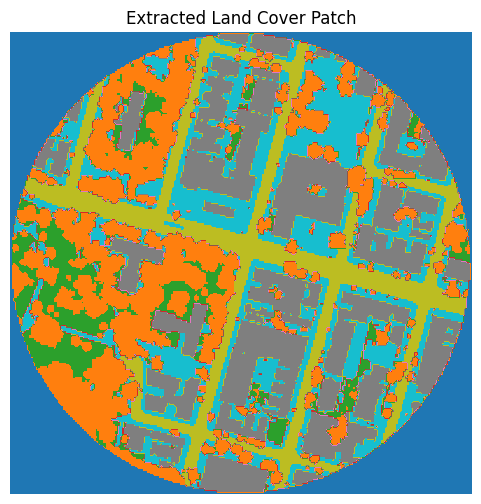

In [73]:
import matplotlib.pyplot as plt
import numpy as np

mapping = {
    0:'Nodata',1: 'tree_canopy', 2: 'grass_shrub', 3: 'bare_ground',
    4: 'open_water', 5: 'building', 6: 'road', 
    7: 'other_impervious', 8: 'railroad'
}
def extract_LandCover_patch(data, point, patch_size_meters=100, plot=False):
    # Create a buffer around the point (converting meters to feet)
    geom = point.buffer(patch_size_meters * 3.28084)
    out_image, _ = rasterio.mask.mask(data, [geom], crop=True, nodata=0)
    patch = out_image[0]
    
    if plot:
        # Create a discrete colormap based on the mapping
        cmap = plt.get_cmap("tab10", len(mapping))
        fig, ax = plt.subplots(figsize=(6, 6))
        img = ax.imshow(patch, cmap=cmap)
        ax.set_title("Extracted Land Cover Patch")
        ax.axis("off")
        plt.show()
    
    return patch


landcover_data = rasterio.open(r"Referentiels/landcover_nyc_2021_6in_Clipped_5.tif")
train_gdf = get_gdf(crs=landcover_data.crs)
patch = extract_LandCover_patch(landcover_data, train_gdf.geometry[0], patch_size_meters=200, plot=True)

In [ ]:
### This Part of the scripted has been copied from the main script LandCover_Polygonized.py, and is shown here for scrutiny purposes 

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
from tqdm.auto import tqdm
from scipy.spatial import cKDTree
import concurrent.futures
from tqdm.auto import tqdm
from geopandas.sindex import SpatialIndex
from multiprocessing import Pool, cpu_count
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')


# Global variables to be initialized in each worker process
global_landcover_gdf = None
global_landcover_sindex = None

def init_worker(landcover_gdf, landcover_sindex):
    """
    Initialize each worker with the global GeoDataFrame and spatial index.
    """
    global global_landcover_gdf, global_landcover_sindex
    global_landcover_gdf = landcover_gdf
    global_landcover_sindex = landcover_sindex


def compute_point_metrics(annulus_geom, landcover_gdf, landcover_sindex, point):
    """
    Compute landcover metrics within a given annulus geometry.
    This version reduces redundant operations and leverages vectorized calculations.
    """
    metrics = {
        'building': 0,
        'grass_shrub': 0,
        'bare_ground':0,
        'open_water':0,
        'railroad':0,
        'other_impervious': 0,
        'road': 0,
        'tree_canopy': 0,
        'building_coverage': 0,
        'grass_shrub_coverage': 0,
        'bare_ground_coverage':0,
        'open_water_coverage':0,
        'railroad_coverage':0,
        'other_impervious_coverage': 0,
        'road_coverage': 0,
        'tree_canopy_coverage': 0,
    }
    
    possible_matches = list(landcover_sindex.intersection(annulus_geom.bounds))
    
    filtered = landcover_gdf.iloc[possible_matches]
    clipped = gpd.clip(filtered, annulus_geom).copy() 

    if clipped.empty:
        return metrics

    clipped["clipped_area"] = clipped.geometry.area
    total_area = clipped["clipped_area"].sum() + 1e-6
    class_areas = clipped.groupby("LandCover_Class")["clipped_area"].sum().to_dict()
    metrics.update(class_areas)
    class_coverage = {k: (v / total_area)*100 for k,v in class_areas.items() }
    metrics.update({f"{cls}_coverage": val for cls, val in class_coverage.items()})
    # --- Water ---
    original_water = filtered[filtered["LandCover_Class"] == "open_water"]
    # --- Vegetation ---
    original_veg = filtered[filtered["LandCover_Class"].isin(["tree_canopy", "grass_shrub"])]
    
    # --- Impervious clipped ---
    impervious_mask_clipped = clipped["LandCover_Class"].isin(["building","bare_ground", "road", "other_impervious", "railroad"])
    clipped_impervious = clipped[impervious_mask_clipped]

    # --- Water Metrics ---
    if not original_water.empty:
        all_water_edges = original_water["boundary"].unary_union
        metrics["closest_water_distance"] = point.distance(all_water_edges)
        # Compute water boundaries once using unary_union
        # Get precomputed centroids and full areas  for IDW-weighted water area calculation
        water_areas = original_water["full_area"].values  # Full area of water bodies

                # Instead of using KDTree with centroids, compute edge distances directly:
        water_edge_distances = np.array([point.distance(boundary) for boundary in original_water["boundary"]])
        water_weights = 1 / (np.square(water_edge_distances) + 1e-6)
        total_water_weight = np.sum(water_weights)
        
        metrics["IDW_full_water_area"] = np.sum(water_areas * water_weights) / total_water_weight if total_water_weight > 0 else 0
        # # Cooling potential: Use clipped water area within annulus
        # clipped_water_area = clipped_water["clipped_area"].sum()
        metrics["water_cooling_potential"] = (water_areas.sum() / total_area) * np.log1p(metrics["IDW_full_water_area"] + 1e-6)

    else:
        metrics.update({
            "closest_water_distance": np.nan,
            "IDW_full_water_area":np.nan,
            "water_cooling_potential":0
        })


    if not original_veg.empty:
        all_veg_edges = original_veg["boundary"].unary_union
        metrics["closest_vegetation_distance"] = point.distance(all_veg_edges)

        veg_areas = original_veg["full_area"].values

        # Corrected: use vegetation boundaries for edge distances
        veg_edge_distances = np.array([point.distance(boundary) for boundary in original_veg["boundary"]])
        veg_weights = 1 / (np.square(veg_edge_distances) + 1e-6)
        veg_total_weight = np.sum(veg_weights)

        veg_patches = original_veg.geometry.unary_union
        metrics["vegetation_edge_ratio"] = veg_patches.length / veg_patches.area
        metrics["vegetation_fragmentation"] = (original_veg.shape[0] / (veg_patches.area + 1e-6))  # Patches per unit area
        metrics["IDW_vegetation_area"] = np.sum(veg_areas * veg_weights) / veg_total_weight if veg_total_weight > 0 else 0

        # Compute vertical complexity (avoid division-by-zero)
        complexities = [poly.area / poly.length for poly in original_veg.geometry if poly.length > 0]
        metrics["vegetation_vertical_complexity"] = np.mean(complexities) if complexities else 0
    else:
        metrics.update({
            "closest_vegetation_distance": np.nan,
            "vegetation_edge_ratio": np.nan,
            "IDW_vegetation_area": 0,
            "vegetation_vertical_complexity": 0,
            "vegetation_fragmentation": 0
        })


    if not clipped_impervious.empty:
        areas = clipped_impervious["full_area"].values

        impervious_edge_distances = np.array([point.distance(poly.boundary) for poly in clipped_impervious.geometry])
        impervious_weights = 1.0 / (np.square(impervious_edge_distances) + 1e-6)
    
        # Distance to nearest impervious edge (full polygons)
        metrics["closest_impervious_distance"] = np.min(impervious_edge_distances)
        metrics["IDW_full_impervious_area"] = np.sum(areas * impervious_weights) / (np.sum(impervious_weights) + 1e-6)
        metrics["largest_impervious_patch"] = clipped_impervious["full_area"].max()

        impervious_agg = clipped_impervious.unary_union
        albedo_map = {"road": 0.1, "building": 0.2, "other_impervious": 0.15, "railroad":0.15}
        clipped_impervious["albedo"] = clipped_impervious["LandCover_Class"].map(albedo_map)
        metrics["effective_albedo"] = ((clipped_impervious["clipped_area"] * clipped_impervious["albedo"]).sum() / total_area)
        metrics["impervious_contiguity"] = impervious_agg.area / total_area
        metrics["impervious_edge_density"] = impervious_agg.length / total_area
    else:
        metrics.update({
                "IDW_full_impervious_area": 0,
                "closest_impervious_distance": np.nan,
                "largest_impervious_patch": 0,
                "impervious_contiguity": 0,
                "impervious_edge_density": 0,
                "effective_albedo": 0})

    # =================================================================
    # 5. Composite UHI Index (Improved Normalization)
    # =================================================================
    try:
        # Normalize metrics to [0,1] range
        norm = {
            "impervious_contiguity": min(metrics.get("impervious_contiguity", 0), 1),
            "vegetation_fragmentation": 1 - np.exp(-metrics.get("vegetation_fragmentation", 0)),
            "effective_albedo": metrics.get("effective_albedo", 0.15) / 0.3  # Assume max 0.3
        }
        
        metrics["UHI_risk_index"] = (
            0.4 * norm["impervious_contiguity"] +
            0.3 * (1 - norm["effective_albedo"]) -
            0.5 * norm["vegetation_fragmentation"] -
            0.2 * (1 / (metrics.get("closest_water_distance", 100) + 1))
        )
    except Exception as e:
        print(f"UHI index error: {e}")
        metrics["UHI_risk_index"] = np.nan

    return metrics


def calculate_landcover_annuli_metrics_vector(gdf, landcover_gdf, landcover_sindex, annuli):
    """Calculate annular metrics with enhanced UHI predictors."""
    
    results = []
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Processing points"):
        point_geom = row.geometry
        row_metrics = {}
        
        # Calculate full-buffer metrics (0 to max radius)
        max_radius = annuli[-1][1]
        full_buffer = point_geom.buffer(max_radius * 3.28084)
        full_metrics = compute_point_metrics(full_buffer, landcover_gdf,landcover_sindex, point_geom)
        for k, v in full_metrics.items():
            row_metrics[f"full_{k}"] = v
            
        # Process annuli
        for inner_r, outer_r in annuli:
            outer_buf = point_geom.buffer(outer_r * 3.28084)
            inner_buf = point_geom.buffer(inner_r * 3.28084)
            annulus_geom = outer_buf.difference(inner_buf)
            
            annulus_metrics = compute_point_metrics(annulus_geom, landcover_gdf,landcover_sindex, point_geom)
            
            # Add annulus-specific metrics
            suffix = f"_{int(inner_r)}_{int(outer_r)}"
            for k, v in annulus_metrics.items():
                row_metrics[k + suffix] = v
        
        results.append(row_metrics)
    
    # Merge results with original data
    metrics_df = pd.DataFrame(results)
    return gdf.join(metrics_df)

def process_row(args):
    """Process one point (row) and compute its full-buffer and annulus metrics."""
    row, annuli = args
    point_geom = row.geometry
    row_metrics = {}
    
    # Compute full-buffer metrics
    # max_radius = annuli[-1][1]
    # full_buffer = point_geom.buffer(max_radius * 3.28084)
    # full_metrics = compute_point_metrics(full_buffer, global_landcover_gdf, global_landcover_sindex, point_geom)
    # for k, v in full_metrics.items():
    #     row_metrics[f"full_{k}"] = v

    # Process each annulus for this point
    for inner_r, outer_r in annuli:
        outer_buf = point_geom.buffer(outer_r * 3.28084)  # Conversion to feet
        inner_buf = point_geom.buffer(inner_r * 3.28084)
        annulus_geom = outer_buf.difference(inner_buf)
        # Note: Make sure you call the correct compute function
        annulus_metrics = compute_point_metrics(annulus_geom, global_landcover_gdf, global_landcover_sindex, point_geom)
        suffix = f"_{int(inner_r)}_{int(outer_r)}"
        for k, v in annulus_metrics.items():
            row_metrics[k + suffix] = v

    return row_metrics


def calculate_landcover_annuli_metrics_vector_parallel(csv_path, landcover_gdf, landcover_sindex, annuli, crs="EPSG:2263"):
    """Calculate annular metrics in parallel across points."""
    # Load the CSV and convert coordinates to a GeoDataFrame
    data_df = pd.read_csv(csv_path)
    geometry = [Point(lon, lat) for lon, lat in zip(data_df['Longitude'], data_df['Latitude'])]
    gdf = gpd.GeoDataFrame(data_df, geometry=geometry, crs="EPSG:4326").to_crs(crs)
    
    # Create a list of arguments for each point
    args_list = [(row, annuli) for _, row in  gdf.iterrows()]
    
    
    if cpu_count() > 1:
        with Pool(
            processes=max(cpu_count() - 1, 1),
            initializer=init_worker,  # Add this line
            initargs=(landcover_gdf, landcover_sindex),  # Pass data to workers
        ) as pool:
            results = list(tqdm(pool.imap(process_row, args_list, chunksize=10), 
                                total=len(args_list)))
    else:
        results = [process_row(args) for args in tqdm(args_list, desc="Mapping LandCover metrics")]
    
    results_df = pd.DataFrame(results)
    # Merge on a unique identifier (e.g., index) to avoid ambiguous merges
    results_df.index.name = "index"
    gdf = gdf.reset_index().set_index("index")
    merged_df = gdf.join(results_df)
    return merged_df


def main():
    gpkg_path = "NYCOpenData/landcover_nyc_2021_6in_Clipped_5_Polygonized.gpkg"
    landcover_gdf = gpd.read_file(gpkg_path).to_crs("EPSG:2263")
    landcover_gdf["full_area"] = landcover_gdf.geometry.area  # Original polygon area
    landcover_gdf["centroid"] = landcover_gdf.geometry.centroid  # Original centroid
    landcover_gdf["boundary"] = landcover_gdf.geometry.boundary
    landcover_gdf["LandCover_Class"] = landcover_gdf.LandCover.map({
        1: 'tree_canopy', 2: 'grass_shrub', 3: 'bare_ground',
        4: 'open_water', 5: 'building', 6: 'road', 
        7: 'other_impervious', 8: 'railroad'
    })
    landcover_sindex = landcover_gdf.sindex  


    annuli_in_meters = [(0, 20), (0, 50), (0, 100), (0, 200),
        (0, 400), (0, 700), (0, 1000) ]

    # Process training data 
    train_result = calculate_landcover_annuli_metrics_vector_parallel(
        csv_path="Train_Data/Training_data_uhi_index_2025-02-18.csv",
        landcover_gdf=landcover_gdf, 
        landcover_sindex=landcover_sindex,
        annuli=annuli_in_meters
    )
    # train_result.to_csv("Train_Data/Final/Polygonized_LandCover_Train_IDW_1kmCircles_18032025.csv", index=False)

    # Process submission data
    submission_result = calculate_landcover_annuli_metrics_vector_parallel(
        csv_path="Submission_Mapped_Data/Submission_template_UHI2025-v2.csv",
        landcover_gdf=landcover_gdf, 
        landcover_sindex=landcover_sindex,
        annuli=annuli_in_meters
    )
    # submission_result.to_csv("Submission_Mapped_Data/Final/Polygonized_LandCover_Submission_IDW_1kmCircles_18032025.csv", index=False)

In [3]:
## Since this part is relatively computationally expensive, The 2 csv train files are already pre-processed and saved in _Train_Processed_Data
train_Landcover = pd.read_csv('_Train_Processed_Data\Polygonized_LandCover_Train_IDW_500Circles_15032025.csv')
train_Landcover.head()

,Longitude,Latitude,datetime,UHI Index,geometry,building_0_25,grass_shrub_0_25,bare_ground_0_25,open_water_0_25,railroad_0_25,...,vegetation_fragmentation_0_1000,IDW_vegetation_area_0_1000,vegetation_vertical_complexity_0_1000,closest_impervious_distance_0_1000,IDW_full_impervious_area_0_1000,largest_impervious_patch_0_1000,effective_albedo_0_1000,impervious_contiguity_0_1000,impervious_edge_density_0_1000,UHI_risk_index_0_1000
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (1009393.6056238374 235526.82444257697),1554.427615,670.040375,0.0,0.0,0.0,...,0.000844,92302.714687,3.242875,3.896372,2.118246e+08,2.668397e+08,0.120611,0.783101,0.022885,0.492151
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (1009388.0927123841 235504.3501299469),2344.736655,1613.585205,0.0,0.0,0.0,...,0.000844,89959.172423,3.239832,3.383604,1.277699e+08,2.668397e+08,0.120702,0.783479,0.022833,0.492211
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (1009380.2758449932 235480.0517512788),2735.382403,2610.414087,0.0,0.0,0.0,...,0.000840,99548.607962,3.241084,0.566881,2.656674e+08,2.668397e+08,0.120814,0.783858,0.022794,0.492253
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (1009372.9197252728 235454.5406141834),2533.560101,2895.483177,0.0,0.0,0.0,...,0.000838,97249.941542,3.241022,1.789095,2.598212e+08,2.668397e+08,0.120905,0.784117,0.022727,0.492265
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (1009368.7914612402 235431.46294374473),2640.922361,2706.357499,0.0,0.0,0.0,...,0.000838,99225.826261,3.241500,0.812473,2.646966e+08,2.668397e+08,0.120960,0.784321,0.022675,0.492292


In [50]:
submission_Landcover = pd.read_csv('_Submission_Processed_Data\Polygonized_LandCover_Submission_IDW_500Circles_15032025.csv')
submission_Landcover.head()

,Longitude,Latitude,UHI Index,geometry,building_0_25,grass_shrub_0_25,bare_ground_0_25,open_water_0_25,railroad_0_25,other_impervious_0_25,...,vegetation_fragmentation_0_1000,IDW_vegetation_area_0_1000,vegetation_vertical_complexity_0_1000,closest_impervious_distance_0_1000,IDW_full_impervious_area_0_1000,largest_impervious_patch_0_1000,effective_albedo_0_1000,impervious_contiguity_0_1000,impervious_edge_density_0_1000,UHI_risk_index_0_1000
0,-73.971665,40.788763,NaN,POINT (992096.2913497823 226645.92586184476),3176.597840,14.484997,0.0,0.0,0.0,1552.532862,...,0.000210,131853.480748,3.304898,0.976297,5838.483789,2.668397e+08,0.083641,0.516131,0.023190,0.422581
1,-73.971928,40.788875,NaN,POINT (992023.3591717415 226686.58759660166),2086.636570,133.280629,0.0,0.0,0.0,3476.161551,...,0.000210,109561.788605,3.302638,4.149668,27231.820991,2.668397e+08,0.083987,0.518532,0.023195,0.423202
2,-73.967080,40.789080,NaN,POINT (993365.8878097676 226761.74352391178),12502.087872,81.132299,0.0,0.0,0.0,6230.750369,...,0.000203,185073.714459,3.393587,1.639609,83369.080992,2.668397e+08,0.073039,0.455886,0.022006,0.408848
3,-73.972550,40.789082,NaN,POINT (991851.1882107009 226761.83001418246),10810.100861,388.860883,0.0,0.0,0.0,4557.008822,...,0.000207,13429.828107,3.311638,4.923181,53381.445676,2.668397e+08,0.084539,0.521216,0.023099,0.423737
4,-73.969697,40.787953,NaN,POINT (992641.4469096478 226350.99752722427),9589.038545,184.988436,0.0,0.0,0.0,1816.517766,...,0.000209,22290.101275,3.315696,19.036842,329330.685691,2.668397e+08,0.079313,0.486463,0.021973,0.414967


## Building FootPrints / Elevation NYC Planimetrics DataBase

The provided Building footprints was used along with NYC Planimetrics Database to construct a new geojson that is basically just a spatial join with the ELEVATION layer found in the geo database. for each Building ID, we associate the mean/median/min/Max building height

accesible via:    https://github.com/CityOfNewYork/nyc-planimetrics/blob/planimetrics-2022/Capture_Rules.md#elevation



### Global Overview
This script extracts urban metrics from building footprint data to generate features for UHI prediction. It uses building geometries and associated attributes (e.g., elevation) to compute a wide range of metrics such as:

- Building density and coverage: How much area within a given annulus is occupied by buildings.

- Distance metrics: Minimum, mean, and standard deviation of distances between a point of interest and nearby building centroids.

- Weighted areas and volumes: Inverse distance weighted (IDW) areas and volumes that capture the influence of nearby buildings.

- Wind and solar obstruction indices: These are proxies for the urban “roughness” that affects heat retention, wind flow, and ultimately local thermal comfort.

- Spatial pattern analysis: Such as nearest-neighbor distances and the Clark–Evans index to quantify the spatial distribution of buildings.

- Building orientation and shape metrics: Average building orientation, compactness, and related metrics that can influence how surfaces absorb and radiate heat.

These metrics are computed for each point (from your training or submission datasets) by considering building footprints within various annuli (i.e., rings around the point). The resulting features are later merged with other data sources and used as predictors in the UHI model.

### How the Building Metrics Help Predict UHI
- Building Density and Coverage:
Higher building density and impervious coverage are typically associated with higher urban heat due to increased heat absorption.

- Distance Metrics (e.g., nearest building distance):
These reflect how close the buildings are, which affects wind flow and heat dispersion.

- Weighted Areas and Volumes:
IDW-weighted building area and volume provide a more nuanced measure than simple counts, emphasizing the influence of nearby large buildings.

- Wind and Solar Obstruction Indices:
These metrics approximate how buildings interfere with wind (affecting cooling) and block sunlight, which influences local temperature.

- Spatial Pattern Analysis:
Metrics like the Clark–Evans index indicate whether building patterns are clustered or dispersed. Clustered buildings can intensify the heat island effect.

- Building Orientation and Compactness:
The orientation affects shading and exposure to sunlight, while compactness (derived from perimeters and areas) gives insight into building shapes that might trap heat.

- Thermal Comfort and Wind Chill Metrics:
Incorporating weather data (temperature, humidity, wind, solar flux) alongside building characteristics allows the model to assess the potential for discomfort or overheating at the microclimate level.

### Wind / Solar Obstruction index

The wind obstruction index in this code quantifies how buildings block the wind from reaching a specific point. It is calculated by combining several factors: the wind direction, the relative bearing of each building from the point, the building’s height (or elevation), and a weight based on the building’s distance to the point. Here’s a breakdown with formulas:

1. **Convert wind direction from degrees to radians:**

$$\theta_{\text{wind}} = \frac{\pi}{180} \times \left(270 - \text{wind\_dir\_deg}\right)$$

Here, subtracting from 270° rotates the reference so that the wind direction is interpreted with respect to the local coordinate system (e.g., ensuring that the wind coming from the north or south is handled appropriately).

2. **Compute each building’s bearing \(\alpha_i\):**


$$\alpha_i = \arctan2\left(\Delta y_i, \Delta x_i\right)$$
This angle α represents the direction from the point to the building in radians.

Δx and Δy are the differences in the x (east-west) and y (north-south) coordinates between the building's centroid and the point.

3. **Calculate the wind contribution for each building:**


$$C_i = \cos\left(\theta_{\text{wind}} - \alpha_i\right) \times h_i \times w_i$$

The cosine term measures the alignment between the wind direction and the direction to the building. 
 - A value near  −1 means the building is directly upwind (blocking the wind),
 - a value near 1 means it is downwind

*where:*
- \( h_i \) is the building's height (or elevation),
- \( w_i \) is a weight factor, typically derived from the inverse square of the distance to the building.

4. **Aggregate contributions (only those that are negative) and scale by wind speed:**

$$\text{Wind Obstruction Index} = \text{wind\_speed} \times \sum_{\{i \mid C_i < 0\}} C_i$$

the wind\_speed is the mean of the windspeed calculated from the nearest station. each Point is assigned the closest station Weather Parameters


In [57]:
### The Whole code and Computation is in the script Projected_Building.py and is shown here for scrutiny purposes
train_Buildings = pd.read_csv('_Train_Processed_Data\Train_Buildings_v14032025_NegativeMask.csv')
train_Buildings.head()

,Longitude,Latitude,datetime,UHI Index,geometry,Region_y,wind_dir_deg,wind_speed,air_temp,rel_humidity,...,avg_compactness_1000_1500,std_compactness_1000_1500,building_volume_density_1000_1500,urban_roughness_proxy_1000_1500,avg_nearest_neighbor_m_1000_1500,clark_evans_index_1000_1500,avg_shadow_length_m_1000_1500,avg_building_orientation_deg_1000_1500,thermal_comfort_index_1000_1500,wind_chill_factor_1000_1500
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (-73.90916667 40.81310667),Bronx,130.26,2.71,27.68,43.48,...,0.526927,0.172832,0.037011,0.0,46.588586,1.143022,112.391335,100.435455,226.821856,29.85995
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (-73.90918667 40.813045),Bronx,130.26,2.71,27.68,43.48,...,0.527112,0.174121,0.036572,0.0,46.667357,1.146893,111.934673,100.345196,225.100082,29.85995
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (-73.909215 40.81297833),Bronx,130.26,2.71,27.68,43.48,...,0.528221,0.175404,0.035956,0.0,46.318990,1.143129,111.660955,101.727228,222.683214,29.85995
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (-73.90924167 40.81290833),Bronx,130.26,2.71,27.68,43.48,...,0.525273,0.173519,0.035093,0.0,45.785556,1.137510,111.840948,102.953999,219.302014,29.85995
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (-73.90925667 40.812845),Bronx,130.26,2.71,27.68,43.48,...,0.523509,0.175101,0.034716,0.0,45.779311,1.141108,111.273489,101.528799,217.824619,29.85995


In [65]:
train_Buildings = pd.read_csv('_Submission_Processed_Data\Submission_Buildings_v14032025_NegativeMask.csv')
train_Buildings = train_Buildings.drop(columns=[ "Region_x"])
train_Buildings.head()

,Longitude,Latitude,UHI Index,geometry,Region_y,wind_dir_deg,wind_speed,air_temp,rel_humidity,solar_flux,...,avg_compactness_1000_1500,std_compactness_1000_1500,building_volume_density_1000_1500,urban_roughness_proxy_1000_1500,avg_nearest_neighbor_m_1000_1500,clark_evans_index_1000_1500,avg_shadow_length_m_1000_1500,avg_building_orientation_deg_1000_1500,thermal_comfort_index_1000_1500,wind_chill_factor_1000_1500
0,-73.971665,40.788763,NaN,POINT (-73.971665 40.78876333),Manhattan,162.21,2.74,26.85,47.72,386.68,...,0.474579,0.198690,0.285056,0.0,69.801220,0.943275,271.178575,126.668229,1198.484397,28.9566
1,-73.971928,40.788875,NaN,POINT (-73.97192833 40.788875),Manhattan,162.21,2.74,26.85,47.72,386.68,...,0.478033,0.198730,0.278586,0.0,69.544155,0.929242,270.015963,125.818257,1173.119269,28.9566
2,-73.967080,40.789080,NaN,POINT (-73.96708 40.78908),Manhattan,162.21,2.74,26.85,47.72,386.68,...,0.471800,0.188968,0.278678,0.0,65.454459,1.098355,272.955393,127.235685,1173.478087,28.9566
3,-73.972550,40.789082,NaN,POINT (-73.97255 40.78908167),Manhattan,162.21,2.74,26.85,47.72,386.68,...,0.480017,0.195112,0.274832,0.0,70.249277,0.891907,268.840351,122.778809,1158.401701,28.9566
4,-73.969697,40.787953,NaN,POINT (-73.96969667 40.78795333),Manhattan,162.21,2.74,26.85,47.72,386.68,...,0.480409,0.189775,0.289084,0.0,64.932583,0.992497,279.855384,124.876756,1214.279256,28.9566


# Training - Feature Selection - HyperParameter Optimization 

## Feature Selection  Using Shapley Values
Since i'm dealing with high dimensionality  ~1600 Features -, an iterative feature selection was performed using Shapley Values. 
it was an interative model training where the least important features were dropped at each training and perfoming the cross-validation & HyperParameter optimization  when reducing the dimensionality to ~250 Features.

In this notebook, i'm only selecting the 300 most important features in one shot

In [3]:
Landsat_Train = pd.read_csv('_Train_Processed_Data/Landsat_Train_V26022024.csv')
Sentinel2_Train = pd.read_csv('_Train_Processed_Data/Sentinel2_Train_v26022025.csv')
satellite_Data = Landsat_Train.merge(Sentinel2_Train, on=["Latitude", "Longitude", "UHI Index"])


Geo_FP_train = pd.read_csv('_Train_Processed_Data/Train_Buildings_v14032025_NegativeMask.csv').select_dtypes("number")
train_FEdata = satellite_Data.merge(Geo_FP_train, on=["Latitude", "Longitude", "UHI Index"])


LandCover_Train = pd.read_csv('_Train_Processed_Data/Polygonized_LandCover_Train_IDW_500Circles_15032025.csv')
LandCover_Train = LandCover_Train.drop(columns=["datetime", "geometry"])
train_FEdata = train_FEdata.merge(LandCover_Train, on=["Latitude", "Longitude", "UHI Index"])


train_FEdata = train_FEdata.drop(columns=["Longitude", "Latitude"])
train_FEdata = train_FEdata.astype('float64')
# train_FEdata.to_csv("Train_Data/Final/Z_Train_Satellite_Weather_PolyLandCover400_Buildings14_Ecostress_HVSR.csv", index=False)

X, y = train_FEdata.drop(columns=['UHI Index']), train_FEdata['UHI Index'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=124)
X_train

,NDVI_Landsat_mean_0_25,GNDVI_Landsat_mean_0_25,EVI_Landsat_mean_0_25,NDWI_Landsat_mean_0_25,MNDWI_Landsat_mean_0_25,NDBI_Landsat_mean_0_25,BUI_Landsat_mean_0_25,NDBSI_Landsat_mean_0_25,BI_Landsat_mean_0_25,BT_Landsat_mean_0_25,...,vegetation_fragmentation_0_1000,IDW_vegetation_area_0_1000,vegetation_vertical_complexity_0_1000,closest_impervious_distance_0_1000,IDW_full_impervious_area_0_1000,largest_impervious_patch_0_1000,effective_albedo_0_1000,impervious_contiguity_0_1000,impervious_edge_density_0_1000,UHI_risk_index_0_1000
8716,0.294441,0.305282,0.178076,-0.305282,-0.994271,0.989137,0.695144,0.994271,0.064850,434.448325,...,0.000327,9798.516317,3.319440,10.965943,9.542861e+07,2.668397e+08,0.076573,0.479484,0.021133,0.414939
6106,0.407660,0.412395,0.276379,-0.412395,-0.994589,0.986194,0.578032,0.994589,0.046487,422.564510,...,0.000594,295866.096158,3.322443,7.489164,1.801045e+08,2.668397e+08,0.073600,0.452092,0.018232,0.406505
8949,0.408768,0.403392,0.239859,-0.403392,-0.995441,0.989137,0.579776,0.995441,0.047739,434.128992,...,0.000508,183563.125752,3.280505,7.088570,1.916305e+08,2.668397e+08,0.107726,0.670120,0.024381,0.459999
648,0.092403,0.131878,0.064781,-0.131878,-0.992443,0.990300,0.897349,0.992443,0.134426,442.563521,...,0.000683,1240.106849,3.283808,14.933344,6.796534e+07,2.668397e+08,0.110421,0.712708,0.020690,0.474092
10499,0.588450,0.552785,0.432913,-0.552785,-0.994842,0.982450,0.393867,0.994842,0.024065,423.669658,...,0.000475,879614.063102,3.324811,1.336466,8.856837e+03,2.668397e+08,0.114494,0.712494,0.025404,0.470199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.241953,0.265321,0.160908,-0.265321,-0.993222,0.988966,0.746815,0.993222,0.079504,430.221231,...,0.000557,397.837926,3.338442,2.183401,1.070991e+07,2.668397e+08,0.110726,0.712969,0.020393,0.473978
9154,0.179236,0.211266,0.128326,-0.211266,-0.992726,0.988994,0.810115,0.992726,0.100112,435.914796,...,0.000428,4226.298379,3.326849,2.167880,9.681917e+06,2.668397e+08,0.114244,0.701449,0.028398,0.466048
8327,0.092279,0.133769,0.055039,-0.133769,-0.994126,0.992583,0.899893,0.994126,0.103231,445.728554,...,0.000760,1305.461761,3.303247,6.222560,1.548640e+08,2.668397e+08,0.109190,0.710859,0.014714,0.474650
4764,0.126013,0.158201,0.102452,-0.158201,-0.990711,0.986782,0.861444,0.990711,0.138811,436.358019,...,0.000671,1112.722742,3.344388,5.008276,1.152344e+08,2.668397e+08,0.104637,0.660425,0.029321,0.459115


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Train a CatBoostRegressor model
params = {
          'iterations': 15000,
          'learning_rate':0.05,
          'depth': 5,
          'loss_function':'RMSE',
          'eval_metric':'R2',
          'subsample':0.8,
          # 'l2_leaf_reg':10,
            'bagging_temperature':10,
          # "min_child_samples":2,
         }
model2 = CatBoostRegressor(**params)
model2.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         metric_period= 20,
         early_stopping_rounds=200,
         plot=True,
         )

predictions = model2.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R2 score: ', r2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0436644	test: 0.0432163	best: 0.0432163 (0)	total: 198ms	remaining: 49m 32s
20:	learn: 0.5083816	test: 0.5209932	best: 0.5209932 (20)	total: 2.29s	remaining: 27m 10s
40:	learn: 0.6555531	test: 0.6744438	best: 0.6744438 (40)	total: 4.03s	remaining: 24m 29s
60:	learn: 0.7245294	test: 0.7411249	best: 0.7411249 (60)	total: 5.73s	remaining: 23m 22s
80:	learn: 0.7621799	test: 0.7768496	best: 0.7768496 (80)	total: 7.4s	remaining: 22m 42s
100:	learn: 0.7893888	test: 0.8006241	best: 0.8006241 (100)	total: 9.1s	remaining: 22m 21s
120:	learn: 0.8112254	test: 0.8202595	best: 0.8202595 (120)	total: 10.8s	remaining: 22m 6s
140:	learn: 0.8268338	test: 0.8344933	best: 0.8344933 (140)	total: 12.4s	remaining: 21m 51s
160:	learn: 0.8421784	test: 0.8468168	best: 0.8468168 (160)	total: 14.1s	remaining: 21m 40s
180:	learn: 0.8549965	test: 0.8570367	best: 0.8570367 (180)	total: 15.8s	remaining: 21m 32s
200:	learn: 0.8657637	test: 0.8659305	best: 0.8659305 (200)	total: 17.5s	remaining: 21m 25s
220

In [9]:
import shap
# explainer = shap.TreeExplainer(model2)
# shap_values = explainer.shap_values(X_test)
# mean_abs_shap = np.abs(shap_values).mean(axis=0)

feature_Importance = pd.DataFrame({
            'feature': X_test.columns,
            'importance': model2.get_feature_importance()
        }).sort_values(by='importance', ascending=False)
feature_Importance.head(60)


,feature,importance
1413,building_volume_density_1000_1500,6.063483
1419,thermal_comfort_index_1000_1500,3.832609
1630,vegetation_vertical_complexity_0_1000,2.000945
1367,avg_building_fp_area_m2_700_1000,1.889668
1313,num_buildings_400_700,1.792127
1401,solar_obstruction_index_1000_1500,1.649740
1379,avg_nearest_neighbor_m_700_1000,1.535449
1489,road_0_100,1.404430
1403,avg_building_fp_area_m2_1000_1500,1.250483
1397,weighted_volume_1000_1500,1.169177


## HyperParameter Optimization - Bayesian optimization using Optuna - Cross validation

In [25]:

# # Get the top  features
top_features = feature_Importance.head(50)['feature'].tolist()

X_train_topFE = X_train[top_features]
X_test_topFE = X_test[top_features]

In [ ]:
### The Main script is in the script Optuna_HyperOptimization.py and is shown here for scrutiny purposes

import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score
import pandas as pd
from functools import partial
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import json



def objective(trial, X, y):

    params = {
        'iterations': 12000,  # Fixed number of iterations
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'depth': trial.suggest_int('depth', 5, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 20),
        'bagging_temperature':trial.suggest_float('leaf_estimation_iterations', 0.5, 10),
        'loss_function': 'RMSE',
        'early_stopping_rounds':150,
        'eval_metric': 'R2',
        'random_seed': 42,
        'verbose': False,  # Suppress CatBoost's internal logs
    }
    
    model = CatBoostRegressor(**params)
    scores = cross_val_score(model, X, y, cv=4, scoring='r2', n_jobs=-1)
    
    return np.mean(scores)


print("Data Loaded, Starting Tuning...")
study = optuna.create_study(direction='maximize')
objective_with_data = partial(objective, X=X, y=y)
study.optimize(objective_with_data, n_trials=25, n_jobs=3)
    
print("Best parameters:", study.best_params)
print("Best Validation R2:", study.best_value)

best Params are used below

## Final Model Training

In [30]:
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train a CatBoostRegressor model
params = {
          'iterations': 50000,   # Controlled by early_stopping
          'learning_rate':0.05,
          'depth': 8,
          'loss_function':'RMSE',
          'eval_metric':'R2',
          'subsample':0.8,
            'l2_leaf_reg':3,
        #   'min_child_samples':2,
          'bagging_temperature':10,
         }

catBoostModel = CatBoostRegressor(**params)
catBoostModel.fit(X_train_topFE, y_train,
         eval_set=(X_test_topFE, y_test),
          early_stopping_rounds=200,
         metric_period= 100,
         plot=True,
         )

# Evaluate the model on the test set
predictions = catBoostModel.predict(X_test_topFE)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R2 score: ', r2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0567931	test: 0.0572688	best: 0.0572688 (0)	total: 30ms	remaining: 25m
100:	learn: 0.8652802	test: 0.8640963	best: 0.8640963 (100)	total: 1.53s	remaining: 12m 37s
200:	learn: 0.9185299	test: 0.9082162	best: 0.9082162 (200)	total: 3.01s	remaining: 12m 25s
300:	learn: 0.9432341	test: 0.9296362	best: 0.9296362 (300)	total: 4.61s	remaining: 12m 41s
400:	learn: 0.9571863	test: 0.9422331	best: 0.9422331 (400)	total: 6.13s	remaining: 12m 37s
500:	learn: 0.9656584	test: 0.9498595	best: 0.9498595 (500)	total: 7.65s	remaining: 12m 35s
600:	learn: 0.9711099	test: 0.9546662	best: 0.9546662 (600)	total: 9.17s	remaining: 12m 33s
700:	learn: 0.9748640	test: 0.9578671	best: 0.9578671 (700)	total: 10.7s	remaining: 12m 32s
800:	learn: 0.9777012	test: 0.9602060	best: 0.9602060 (800)	total: 12.2s	remaining: 12m 27s
900:	learn: 0.9799287	test: 0.9621795	best: 0.9621795 (900)	total: 13.7s	remaining: 12m 24s
1000:	learn: 0.9817473	test: 0.9637111	best: 0.9637111 (1000)	total: 15.2s	remaining: 12m

## Explainability - Shap Values

Shapley values provide a game-theoretic way to fairly attribute the contribution of each feature to a model's prediction. By analyzing Shapley values for a given location, you can identify which features (such as high impervious surface, low vegetation, or specific thermal indices) are pushing the prediction toward a hotspot, and which ones are pushing it toward a cool spot. This not only helps in interpreting the model’s decision for individual cases (local interpretability) but also highlights overall trends in how different urban features influence temperature extremes (global interpretability).

In [31]:
import shap
explainer = shap.TreeExplainer(catBoostModel)
shap_values = explainer.shap_values(X_test_topFE)
mean_abs_shap = np.abs(shap_values).mean(axis=0)


feature_Importance = pd.DataFrame({
            'feature': X_test_topFE.columns,
            'importance': np.abs(shap_values).mean(axis=0)
        }).sort_values(by='importance', ascending=False)
feature_Importance.head(60)


,feature,importance
24,Albedo_median_75_150,0.001280
3,avg_building_fp_area_m2_700_1000,0.001254
23,LST_Proxy_std_250_500,0.000945
25,LST_gradient_x_sum_150_250,0.000839
14,min_height_1000_1500,0.000761
17,road_coverage_0_500,0.000715
4,num_buildings_400_700,0.000708
1,thermal_comfort_index_1000_1500,0.000673
10,vegetation_vertical_complexity_0_700,0.000653
0,building_volume_density_1000_1500,0.000641


### Local explainability

The base value (or expected value) represents the average model output over the training dataset. The contributions (SHAP values) shown for each feature add up to push the prediction from this base value. The red features push the prediction higher, while blue features push it lower.

#### Hotspot

In [32]:
hotSpot_index = np.argmax(predictions)
shap.initjs()

# generate force plot for the first instance in your test set
shap.force_plot(explainer.expected_value, shap_values[hotSpot_index,:], X_test_topFE.iloc[hotSpot_index,:])

#### Cool Spot

In [33]:
coolSpot_index = np.argmin(predictions)
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[coolSpot_index,:], X_test_topFE.iloc[coolSpot_index,:])

### Global explainability

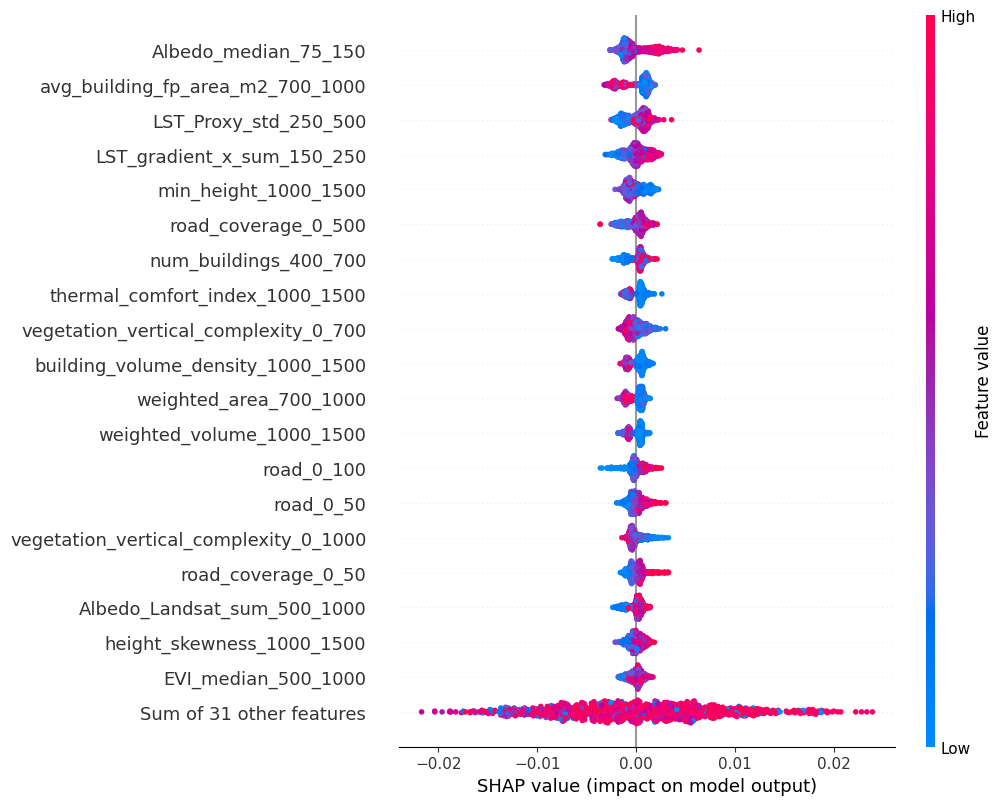

In [34]:
explainer = shap.TreeExplainer(catBoostModel)
shap_values = explainer(X_test_topFE)
shap.plots.beeswarm(shap_values, max_display=20)

In [35]:
## Final model training before submission
X_train_topFE = X[top_features]   # Taking all Observations

params = {
          'iterations': 20000,   # Controlled by early_stopping
          'learning_rate':0.05,
          'depth': 8,
          'loss_function':'RMSE',
          'eval_metric':'R2',
          'subsample':0.8,
            'l2_leaf_reg':3,
        #   'min_child_samples':2,
          'bagging_temperature':10,
         }

Final_catBoostModel = CatBoostRegressor(**params)
Final_catBoostModel.fit(X_train_topFE, y,
         metric_period= 100,
         )

0:	learn: 0.0572061	total: 30.9ms	remaining: 10m 18s
100:	learn: 0.8666820	total: 1.58s	remaining: 5m 11s
200:	learn: 0.9199690	total: 3.14s	remaining: 5m 9s
300:	learn: 0.9438398	total: 4.6s	remaining: 5m
400:	learn: 0.9577995	total: 6.07s	remaining: 4m 56s
500:	learn: 0.9658437	total: 7.62s	remaining: 4m 56s
600:	learn: 0.9711700	total: 9.23s	remaining: 4m 58s
700:	learn: 0.9749526	total: 10.9s	remaining: 4m 59s
800:	learn: 0.9778161	total: 12.4s	remaining: 4m 58s
900:	learn: 0.9799779	total: 14.1s	remaining: 4m 58s
1000:	learn: 0.9817461	total: 15.7s	remaining: 4m 57s
1100:	learn: 0.9831326	total: 17.3s	remaining: 4m 57s
1200:	learn: 0.9843881	total: 19s	remaining: 4m 56s
1300:	learn: 0.9854778	total: 20.7s	remaining: 4m 57s
1400:	learn: 0.9864400	total: 22.4s	remaining: 4m 57s
1500:	learn: 0.9872687	total: 24s	remaining: 4m 56s
1600:	learn: 0.9879774	total: 25.6s	remaining: 4m 54s
1700:	learn: 0.9886473	total: 27.3s	remaining: 4m 53s
1800:	learn: 0.9892709	total: 28.9s	remaining: 4

### Save the Model

In [36]:
import json
Final_catBoostModel.save_model("_Models/Final_Catboost_Model.cbm")

with open("_Models/Final_Model_Features.json", "w") as f:
    json.dump(top_features, f)  

# Submission

### Loading the Model & Features

In [37]:
import json
loaded_cbm= CatBoostRegressor()      
loaded_cbm.load_model('_Models/Final_Catboost_Model.cbm')

with open("_Models/Final_Model_Features.json") as f:
    loaded_top_features = json.load(f)
    print("number of Top features : ",len(loaded_top_features))


number of Top features :  50


In [38]:
Landsat_Sub = pd.read_csv('_Submission_Processed_Data/Landsat_Submission_V26022024.csv')
Sentinel2_Sub = pd.read_csv('_Submission_Processed_Data/Sentinel2_Submission_v26022025.csv')
satellite_Data_Sub = Landsat_Sub.merge(Sentinel2_Sub, on=["Latitude", "Longitude"])


Geo_FP_Sub = pd.read_csv('_Submission_Processed_Data/Submission_Buildings_v14032025_NegativeMask.csv').select_dtypes("number")
Sub_FEdata = satellite_Data_Sub.merge(Geo_FP_Sub, on=["Latitude", "Longitude"])
Sub_FEdata

LandCover_Sub = pd.read_csv('_Submission_Processed_Data/Polygonized_LandCover_Submission_IDW_500Circles_15032025.csv')
LandCover_Sub = LandCover_Sub.drop(columns=["geometry", "UHI Index"])
Sub_FEdata = Sub_FEdata.merge(LandCover_Sub, on=["Latitude", "Longitude"])


X_val = Sub_FEdata.drop(columns=["Longitude", "Latitude"])

X_val = Sub_FEdata.astype('float64')
X_val= Sub_FEdata[top_features]
X_val


,building_volume_density_1000_1500,thermal_comfort_index_1000_1500,vegetation_vertical_complexity_0_1000,avg_building_fp_area_m2_700_1000,num_buildings_400_700,solar_obstruction_index_1000_1500,avg_nearest_neighbor_m_700_1000,road_0_100,avg_building_fp_area_m2_1000_1500,weighted_volume_1000_1500,...,max_height_1000_1500,normalized_wind_obstruction_index_200_400,water_cooling_potential_0_500,railroad_0_200,THI_Landsat_median_500_1000,EUHI_Landsat_median_500_1000,road_coverage_0_50,vegetation_fragmentation_0_700,TEI_std_250_500,Albedo_Landsat_sum_500_1000
0,0.285056,1198.484397,3.304898,2604.952806,108,0.110225,62.216961,29521.074748,4087.572970,1.117614e+06,...,533.250000,-280.286452,191.867845,0.000000,1678.479231,1560.472796,3.333891,0.000191,15927.535761,1655.124552
1,0.278586,1173.119269,3.302638,2546.535877,109,0.107724,62.420620,13326.784590,4014.271246,1.092249e+06,...,533.250000,-262.019052,192.990650,0.000000,1673.201492,1570.269372,3.583632,0.000193,17023.912242,1657.512980
2,0.278678,1173.478087,3.393587,2499.582991,81,0.107759,60.146539,40190.644668,4089.337095,1.092608e+06,...,603.720802,-140.539163,175.320094,0.000000,1574.200469,1099.196421,15.639615,0.000147,13211.794426,1541.633149
3,0.274832,1158.401701,3.311638,2558.058425,108,0.106272,60.252606,16217.768647,3999.520801,1.077531e+06,...,533.250000,-324.698939,195.352308,0.000000,1709.716237,1588.003466,5.676064,0.000197,17402.527375,1656.456350
4,0.289084,1214.279256,3.315696,2898.374390,97,0.111783,64.111767,8738.730149,4089.921742,1.133409e+06,...,553.795460,-272.304006,182.341437,0.000000,1788.807828,1429.465677,2.192000,0.000151,16872.625264,1595.849263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0.038687,233.392758,3.202227,1232.189850,206,0.021292,43.135596,66764.160082,1401.637349,1.516805e+05,...,308.927992,-217.054738,415.884606,0.000000,2048.092714,2022.116475,31.198747,0.000709,44515.570835,2023.154281
1036,0.077899,387.129709,3.335558,1576.775686,130,0.042873,44.560248,72471.462562,1722.239924,3.054175e+05,...,484.491737,-1157.059310,3.994541,176461.774960,2016.252130,1576.398146,16.133079,0.000419,133186.284670,1825.657842
1037,0.061252,321.019429,3.146626,1904.286207,149,0.023685,51.076105,43532.245821,1428.423964,2.401490e+05,...,484.491737,-581.542067,104.228680,0.000000,3116.630104,1513.115462,17.905233,0.000366,51906.040393,1801.938439
1038,0.038200,231.483298,3.223554,1296.542145,239,0.021024,43.067006,76295.205062,1386.517522,1.497711e+05,...,308.927992,-161.637192,415.884606,13789.963501,1834.409235,1815.213106,19.321777,0.000645,52971.278428,1997.235582


In [39]:
 #     #Making predictions
final_predictions = Final_catBoostModel.predict(X_val)
final_prediction_series = pd.Series(final_predictions)

submission_df = pd.DataFrame({'Longitude':Sub_FEdata['Longitude'].values, 
                                'Latitude':Sub_FEdata['Latitude'].values, 
                                'UHI Index':final_prediction_series.values})
submission_df.to_csv("submission_Assesment.csv",index = False)
submission_df                            

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.963568
1,-73.971928,40.788875,0.963018
2,-73.967080,40.789080,0.962602
3,-73.972550,40.789082,0.961530
4,-73.969697,40.787953,0.960562
...,...,...,...
1035,-73.919388,40.813803,1.039403
1036,-73.931033,40.833178,1.040915
1037,-73.934647,40.854542,1.039538
1038,-73.917223,40.815413,1.039318
